# Walkthrough

This notebook will walk you through an example run of a simulation of a PYMK universe and how to compare the naive estimator to the MDI estimator for different parameter values and algorithms.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import itertools as it
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)
import sys
sys.path.append('./')
import main
import utils
import cfns
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')

We choose a random seed:

In [2]:
seed = 100

We create the undirected latent graph here in edge list (set) form:

In [21]:
nbr_of_nodes = 400

In [22]:
H = nx.barabasi_albert_graph(n=nbr_of_nodes, m=50)
true_edges = set(H.edges())
true_edges.update([(j, i) for i, j in true_edges])

We settle on a horizon time (should be << nbr_of_nodes):

In [23]:
T = 50

We create the fixed algorithms here:

In [24]:
sigma_B = utils.random_ranking(nbr_of_nodes)
simil = 250000  # A parameter controlling the similarity between algos
sigma_A = cfns.make_stronger_algo(sigma_B, simil, T, true_edges)

We run the ground truth (where everyone is treated):

In [25]:
bucket_assignment = np.ones(nbr_of_nodes, dtype=int)

In [26]:
ground_truth = len(cfns.process_strongly_fixed(sigma = sigma_A, T=T,
                                               true_edges=true_edges,
                                               seed=seed)[0])

We now run 200 completely randomized A/B tests where we select first the proportion of treated units: 
(Note this sampling is independent from the random seed chosen above)

In [27]:
proportion_treated = .5

In [28]:
naive, mdi = cfns.run_strongly_fixed(T=T, 
                                     true_edges=true_edges,
                                     treatment=sigma_A,
                                     control=sigma_B,
                                     proportion=proportion_treated,
                                     n_iter=200,
                                     seed=seed)

Note that the same workflow is possible for weakly fixed algorithms:

In [29]:
ground_truth = len(cfns.process_weakly_fixed(sigma = sigma_A, T=T,
                                               true_edges=true_edges,
                                               seed=seed)[0])

In [30]:
naive, mdi = cfns.run_weakly_fixed(T=T, 
                                   true_edges=true_edges,
                                   treatment=sigma_A,
                                   control=sigma_B,
                                   proportion=proportion_treated,
                                   n_iter=200,
                                   seed=seed)

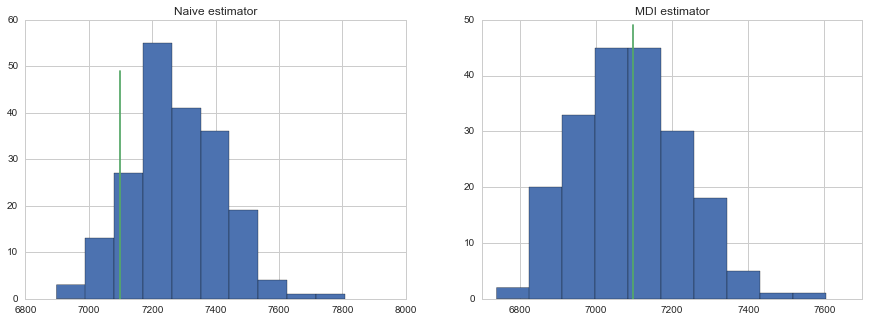

In [31]:
f, axarr = plt.subplots(1, 2, figsize=(15, 5))
axarr[0].hist(naive)
axarr[0].set_title('Naive estimator')
axarr[1].hist(mdi)
axarr[1].set_title('MDI estimator')
for ax in axarr:
    ax.plot([ground_truth] * 50, range(50))

For non-fixed algorithms, the workflow is slightly different. It requires setting a buffer variable such that T + buffer << N but buffer ~ T. This is for optimization purposes: the output of the program is independent from the value of the buffer. 

In [32]:
buffer = 50

We can cast the fixed algorithms as non-fixed algorithms for compatibilty:

In [33]:
control = cfns.PermutationAlgorithm(sigma_B)

We can also create mixture algorithms between fixed algorithms and FoF algorithm by specifying a mixture parameter:

In [34]:
mixture_parameter = .01

In [35]:
treatment = cfns.FoFandPermutationAlgorithm(sigma_A, epsilon=mixture_parameter)

Running the ground truth is slightly different now:

In [36]:
bucket_assignment = np.ones(nbr_of_nodes, dtype=int)

In [37]:
ground_truth = len(cfns.process_nonfixed(true_edges=true_edges,
                                         treatment=treatment,
                                         control=control,
                                         buckets=bucket_assignment,
                                         N=nbr_of_nodes,
                                         T=T, seed=seed,
                                         buff=buffer)[0])

Note that running the 200 A/B tests will return 3 estimators: the naive estimator, the standard MDI estimator, and the partial MDI estimator discussed at the end of Section~3. 

In [38]:
naive, partial_mdi, full_mdi = cfns.run_nonfixed(T=T,
                                                 true_edges=true_edges,
                                                 treatment=treatment,
                                                 control=control,
                                                 proportion=proportion_treated,
                                                 N=nbr_of_nodes,
                                                 buff=buffer,
                                                 n_iter=200,
                                                 seed=seed)

/Users/jpa/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


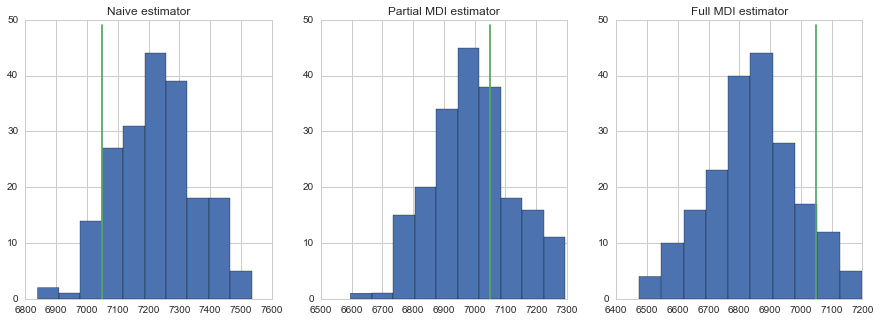

In [44]:
f, axarr = plt.subplots(1, 3, figsize=(15, 5))
axarr[0].hist(naive[1:])
axarr[0].set_title('Naive estimator')
axarr[1].hist(partial_mdi[1:])
axarr[1].set_title('Partial MDI estimator')
axarr[2].hist(full_mdi[1:])
axarr[2].set_title('Full MDI estimator')
for ax in axarr:
    ax.plot([ground_truth] * 50, range(50))